# Week 4 Project - Predicting Employee Attrition with IBM HR Analytics Dataset

## 🎯 Objective
Build a machine learning model that predicts whether an employee is likely to leave the company using HR data. The project involves data preprocessing, exploratory data analysis, model building, evaluation, and interpretation to support HR decision-making.


## Step 1: Load Required Libraries
Import essential libraries for data analysis, visualization, and machine learning.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings("ignore")

e:\Maroofa_Data\Desktop\data analyst\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load Dataset
Load the IBM HR Analytics dataset and preview the first few records.


In [10]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
print(df.shape)
df.head()

(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Step 3: Explore the Data
Understand the structure, data types, and distribution of values in key columns.


In [11]:
print(df.info())
print(df.describe())
print(df['Attrition'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

## Step 4: Visualize Initial Insights
Use countplots and boxplots to uncover initial patterns in attrition by department, job role, and salary.


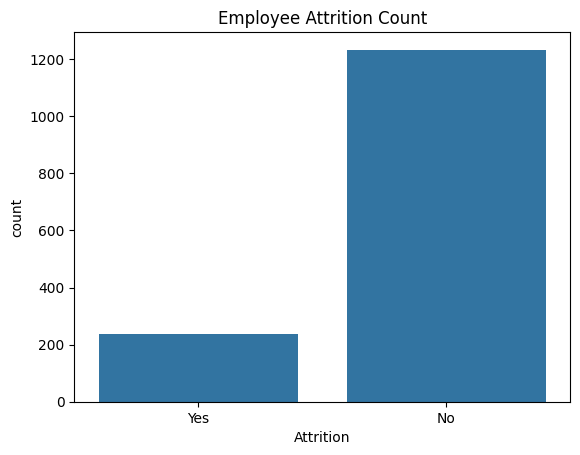

In [12]:
sns.countplot(data=df, x='Attrition')
plt.title("Employee Attrition Count")
plt.show()

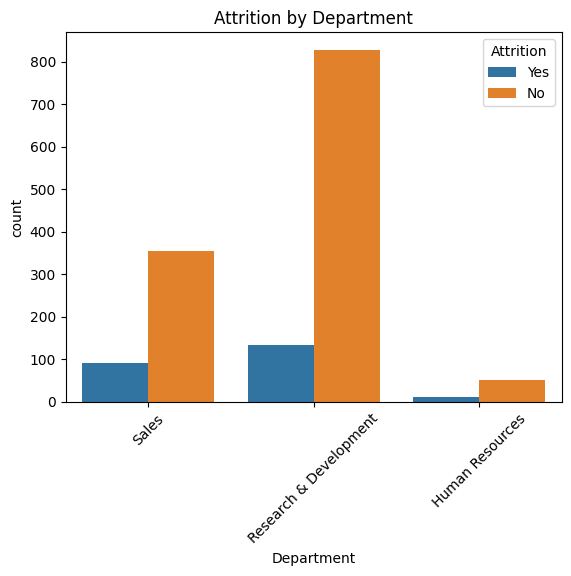

In [13]:
sns.countplot(data=df, x='Department', hue='Attrition')
plt.title("Attrition by Department")
plt.xticks(rotation=45)
plt.show()

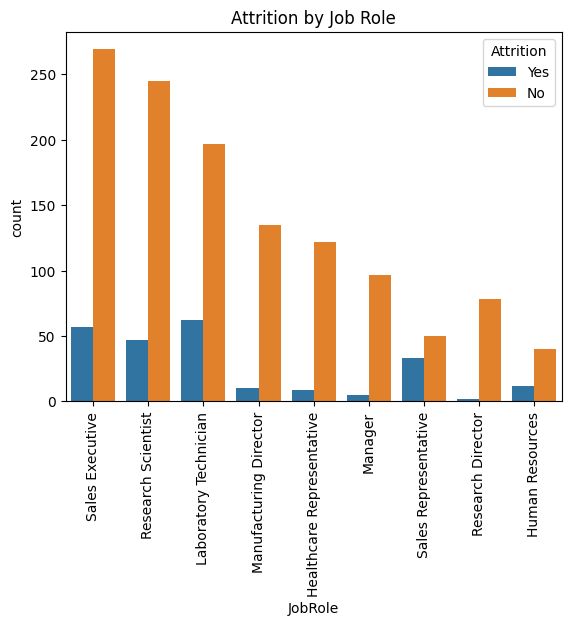

In [14]:
sns.countplot(data=df, x='JobRole', hue='Attrition')
plt.title("Attrition by Job Role")
plt.xticks(rotation=90)
plt.show()

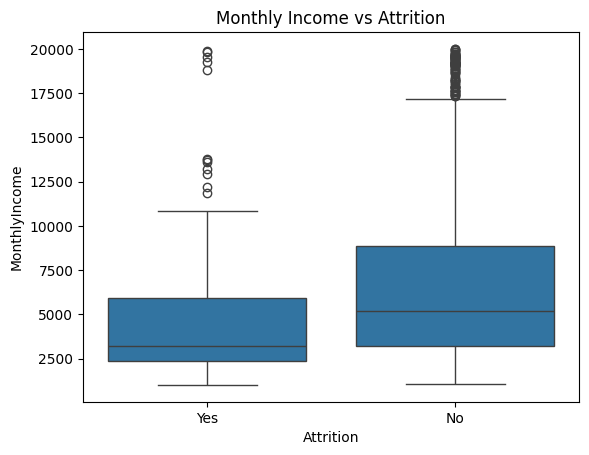

In [15]:
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title("Monthly Income vs Attrition")
plt.show()

##  Step 5: Data Preprocessing
- Encode categorical variables
- Drop unnecessary columns
- Scale numerical features


In [16]:
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])
df['OverTime'] = le.fit_transform(df['OverTime'])

In [17]:
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1, inplace=True)

In [18]:
df = pd.get_dummies(df, drop_first=True)

In [19]:
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop('Attrition')
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [20]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

## Step 6: Handle Class Imbalance
Use SMOTE to oversample the minority class (attrition = yes) and balance the dataset.


In [21]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

## Step 7: Model Building
Train Logistic Regression, Random Forest, and XGBoost classifiers to predict employee attrition.


In [23]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       250
           1       0.92      0.86      0.89       244

    accuracy                           0.89       494
   macro avg       0.89      0.89      0.89       494
weighted avg       0.89      0.89      0.89       494



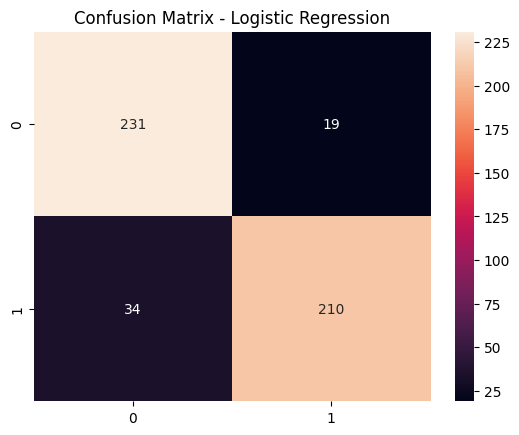


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       250
           1       0.96      0.91      0.93       244

    accuracy                           0.94       494
   macro avg       0.94      0.93      0.94       494
weighted avg       0.94      0.94      0.94       494



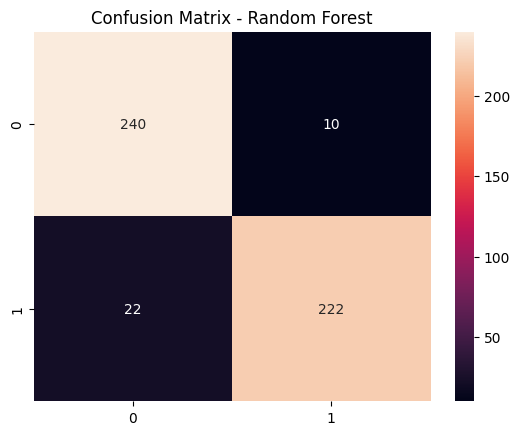


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       250
           1       0.94      0.89      0.92       244

    accuracy                           0.92       494
   macro avg       0.92      0.92      0.92       494
weighted avg       0.92      0.92      0.92       494



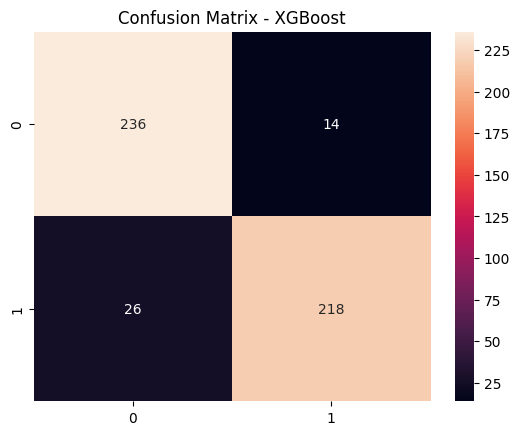

In [24]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


## Step 8: Evaluate Model Performance
Compare the models using classification reports and confusion matrices. Focus on recall to minimize false negatives.


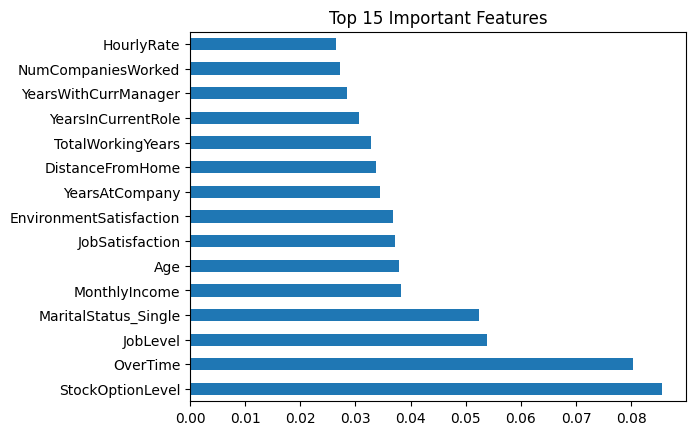

In [25]:
rf_model = models['Random Forest']
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Important Features")
plt.show()

## Step 9: Feature Importance & SHAP
Visualize top features influencing attrition using:
- Random Forest feature importances
- SHAP summary plots for interpretability


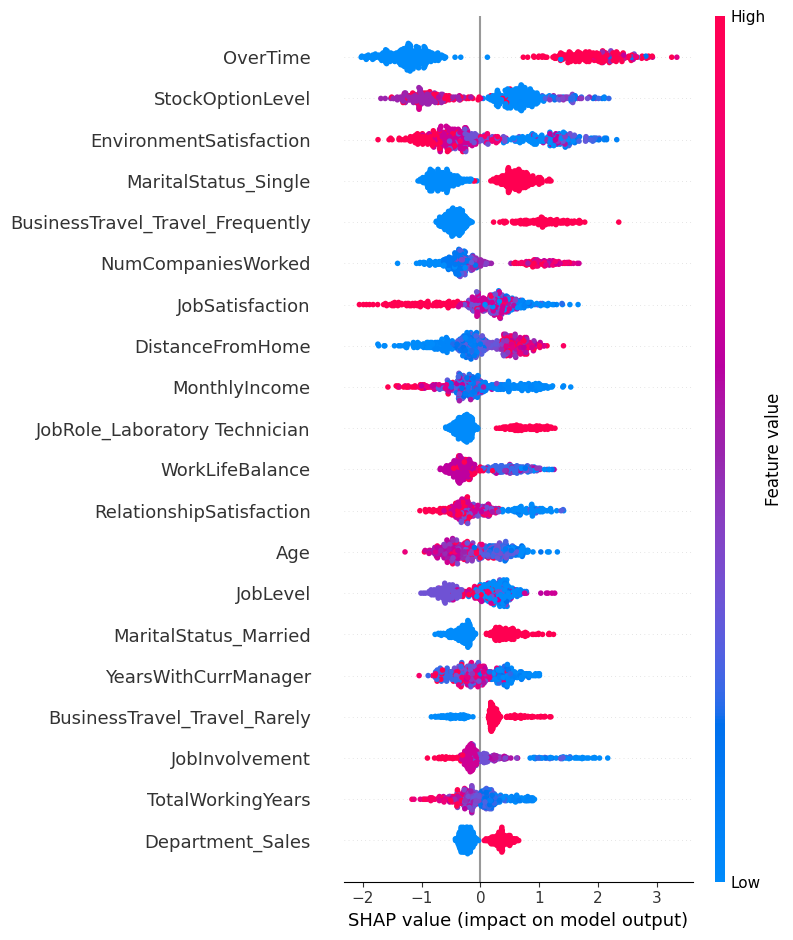

In [26]:
explainer = shap.TreeExplainer(models['XGBoost'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [27]:
print("\nConclusion: The Random Forest and XGBoost models performed well. Key factors like OverTime, JobSatisfaction, and EnvironmentSatisfaction have high influence on attrition.")


Conclusion: The Random Forest and XGBoost models performed well. Key factors like OverTime, JobSatisfaction, and EnvironmentSatisfaction have high influence on attrition.


## Step 10: Conclusion

- Random Forest and XGBoost models performed best.
- Key drivers of attrition include: OverTime, JobSatisfaction, EnvironmentSatisfaction, and MonthlyIncome.
- HR can use this model to proactively retain employees likely to resign.

**Next Steps:** Integrate this into HR dashboards or use it for targeted employee retention programs.
